In [1]:
from climpyrical.gridding import find_nearest_index, find_element_wise_nearest_pos
from climpyrical.mask import gen_raster_mask_from_vector, gen_upper_archipelago_mask
import climpyrical.spytialProcess as sp
from climpyrical.rkrig import krigit_north

from pkg_resources import resource_filename


from rpy2.robjects.packages import importr
import xarray as xr
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from scipy.interpolate import NearestNDInterpolator
from sklearn.neighbors import NearestNeighbors

from tqdm import tqdm
import dask.array as da
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import matplotlib


from pykrige.ok import OrdinaryKriging

importr("fields")


%load_ext autoreload
%autoreload 2

In [2]:
OLD_PATH = resource_filename(
    'climpyrical',
    'nrc_data/snw_rain_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc'
)

dsold = xr.open_dataset(OLD_PATH)
dsold_max = dsold.rlat.values.max()

DS_PATH = resource_filename(
    'climpyrical',
    'nrc_data/processed/pre_processed.nc'
)

MASK_PATH = resource_filename(
    'climpyrical',
    'nrc_data/processed/canada_mask_rp.nc'
)

ds = xr.open_dataset(DS_PATH)
dv = list(ds.data_vars)[0]
mask = xr.open_dataset(MASK_PATH)['mask'].values

In [3]:
station_dv = 'RL50 (kPa)'
# station_dv = 'mean RH (%)'
# station_dv = 'SL50 (kPa)'
# station_dv = 'TJan2.5 (degC)'
# station_dv = 'HDD (degC-day)'
# station_dv = 'Q10_Gumbel-MM'
# station_dv = 'Q50_Gumbel-MM'

In [4]:
file_dv = station_dv.split(' ')[0]
df_path = resource_filename('climpyrical', 'nrc_data/processed/processed_station.csv')

df = pd.read_csv(df_path, index_col=False)
df_nrc = pd.read_csv('./data/processed/nrc_locations.csv')

In [5]:
alert_rlon, alert_rlat = 5.279164, 36.203886
alert_lon, alert_lat = -62.3333, 82.5


df[df.station_name.str.contains('ALERT')].values
# alert coords

array([[308, 805, 354, 0.5870000000000001, 6.67474722724466,
        -18.60226561413381, 50.5833, -126.933, 'ALERT BAY',
        0.8464460954074441, 0.5676831122441911, 0.8185914033864417]],
      dtype=object)

In [6]:
df_north = df[df.rlat > dsold_max].copy()
df_south = df[df.rlat <= dsold_max].copy()

north_index = df_north.index.values
south_index = df_south.index.values

In [26]:
df[df.station_name.str.contains('alert')]

,Unnamed: 0,ilocy,ilocx,RL50 (kPa),rlat,rlon,lat,lon,station_name,ratio,model_vals,best_tol


# Krig the station only values in the north

In [24]:
# dummy array to force 14 nearest stations to Alert 
alert_arr = [[495, 1472, 894, 235.85, 36.20388623771783, 5.279164142263307,
        82.5, -62.3333, 'ALERT CLIMATE', 1.0091788499249528,
        234.48550962410286, 1.0033403304071171]]

temp_infill = True
if temp_infill:
    if np.any(df.station_name.str.contains('ALERT')) or np.any(df.station_name.str.contains('alert')):
        print("ALERT")
        station_final_north_UAA = ~np.isnan(krigit_north(df, station_dv, 15, ds, extrap=False))

    else:
        # Add in the coords for alert
        print("No ALERT")
        df_cp = df.append(pd.DataFrame(alert_arr, columns=df.columns))
        station_final_north_UAA = ~np.isnan(krigit_north(df_cp, station_dv, 15, ds, extrap=False))
else:
    station_final_north = krigit_north(df, station_dv, 15, ds, extrap=True)

UAA_station_mean = np.nanmean(df[station_dv][df.rlat > dsold_max-1])

ALERT


In [22]:
canada = gpd.read_file('./data/processed/canada_final.shp').geometry

100%|██████████| 59147/59147 [00:09<00:00, 6546.57it/s]


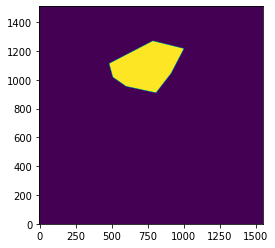

In [23]:
northern_mask = gen_upper_archipelago_mask(canada, ds.rlon.values, ds.rlat.values, 210, dsold_max)
station_final_north[~northern_mask] = np.nan

plt.imshow(northern_mask, origin='lower')
plt.imshow(station_final_north_UAA, origin='lower')

## Find areas in north that are not covered by station only reconstruction

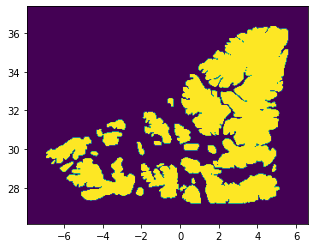

In [21]:
from sklearn.neighbors import KNeighborsRegressor
knr = KNeighborsRegressor(n_neighbors=5, weights='uniform', metric='euclidean')

north_nan = ~np.isnan(station_final_north)
missed_station_only = (northern_mask^north_nan)

extent = [ds.rlon.values.min(), ds.rlon.values.max(), ds.rlat.values.min(), ds.rlat.values.max()]

plt.imshow(missed_station_only, origin='lower', extent=extent)
plt.gca().set_ylim(M2.bounds.miny.min()-1, M2.bounds.maxy.max()+1)
plt.gca().set_xlim(M2.bounds.minx.min()-1, M2.bounds.maxx.max()+1)
plt.show()

station_final_north[~northern_mask] = np.nan

rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)
f = NearestNDInterpolator(np.stack([rlon[north_nan], rlat[north_nan]]).T, station_final_north[north_nan])
# knr.fit(np.stack([rlon[north_nan], rlat[north_nan]]).T, station_final_north[north_nan])
# knr.fit(np.stack([df.rlon, df.rlat]).T, df[station_dv])


station_final_north_filled = station_final_north.copy()
station_final_north_filled[missed_station_only] = f(np.stack([rlon[missed_station_only], rlat[missed_station_only]]).T)
# station_final_north_filled[missed_station_only] = knr.predict(np.stack([rlon[missed_station_only], rlat[missed_station_only]]).T)
station_final_north_filled[~northern_mask] = np.nan

# knr.predict(np.stack([rlon[missed_station_only], rlat[missed_station_only]]).T)

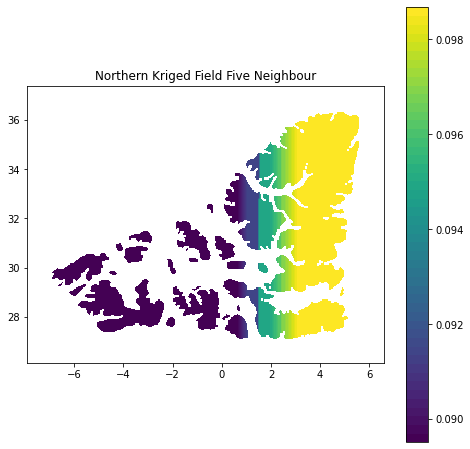

In [22]:
# matplotlib.rc('font', **font)

extent = [ds.rlon.values.min(), ds.rlon.values.max(), ds.rlat.values.min(), ds.rlat.values.max()]
fig, ax = plt.subplots(figsize=(8, 8))
img = ax.imshow(station_final_north_filled, origin='lower', extent = extent, cmap = plt.cm.get_cmap("viridis", 50))
# img = ax.imshow(station_final_north_filled-273.15, origin='lower', extent = extent, cmap = plt.cm.get_cmap("viridis", 50))

plt.scatter(df_north.rlon, df_north.rlat, color='r')
ax.set_ylim(M2.bounds.miny.min()-1, M2.bounds.maxy.max()+1)
ax.set_xlim(M2.bounds.minx.min()-1, M2.bounds.maxx.max()+1)
plt.colorbar(img)
plt.title("Northern Kriged Field Five Neighbour")
plt.savefig("northern_krig_5_neighbour")

In [23]:
ix, iy = find_element_wise_nearest_pos(
            ds.rlon.values, 
            ds.rlat.values, 
            df.rlon.values, 
            df.rlat.values
)

df['ilocy'] = iy 
df['ilocx'] = ix

In [1]:
# choose starting value
model_vals = ds[dv].values[df.ilocy.values, df.ilocx.values]
station_vals = df[station_dv]
best_tol = df.best_tol.mean()    

print(best_tol)

# apply correction
model_vals_corrected = (model_vals/best_tol)# + 273.15
mean_corrected = (ds[dv].values/best_tol)# + 273.15

NameError: name 'ds' is not defined

In [25]:
np.nanmean(mean_corrected), np.nanmin(ds[dv].values)

(0.1861698410580522, 0.0009741167111742323)

In [26]:
# latlon = np.stack([df.rlon, df.rlat])
# hull = ConvexHull(points=latlon.T)
# poly = Polygon(latlon.T[hull.vertices])
# poly_mask = gen_raster_mask_from_vector(ds.rlon.values, ds.rlat.values[l:r], gpd.GeoSeries(poly), progress_bar=False)
# plt.imshow(poly_mask)

In [27]:
# ok = OrdinaryKriging(
#     df.rlon, 
#     df.rlat, 
#     df.ratio, 
#     exact_values=False,
#     variogram_function='exponential',
# )
# z, ss = ok.execute("grid", ds.rlon.values, ds.rlat.values, backend='C', n_closest_points=30)

In [28]:
df[['rlon', 'rlat', 'ratio']].values[:, :2]

import rpy2

In [29]:
from climpyrical.rkrig import rkrig_r

ratio = rkrig_r(df_south, 30, ds, station_dv)
ratio[~mask] = np.nan

 61%|██████    | 251/411 [02:03<01:55,  1.38it/s]R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages

R[write to console]: 3: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/

In [30]:
cxmin, cxmax, cymin, cymax = canada.bounds.minx.min(), canada.bounds.maxx.max(), canada.bounds.miny.min(), canada.bounds.maxy.max()

/home/nannau/tri/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

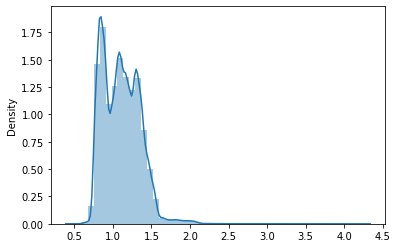

In [31]:
import seaborn as sns
sns.distplot(ratio[~np.isnan(ratio)])

In [32]:
from shapely.geometry import MultiPolygon
pts=[]
for poly in canada:
    if isinstance(poly, MultiPolygon):
        for p in poly:
            pts.extend(p.exterior.coords)
            pts.append([None, None])
    else:
        pts.extend(poly.exterior.coords)
        pts.append([None, None])

X, Y = zip(*pts)

In [33]:
path = resource_filename("climpyrical", "/r-library")
import rpy2.robjects.packages as rpackages
from rpy2 import robjects



utils = rpackages.importr("utils")

rpath = resource_filename("climpyrical", "/r-library")
libPath = robjects.r(".libPaths")
libPath(rpath)

importr("fields", rpath)


rpy2.robjects.packages.Package as a <module 'fields'>

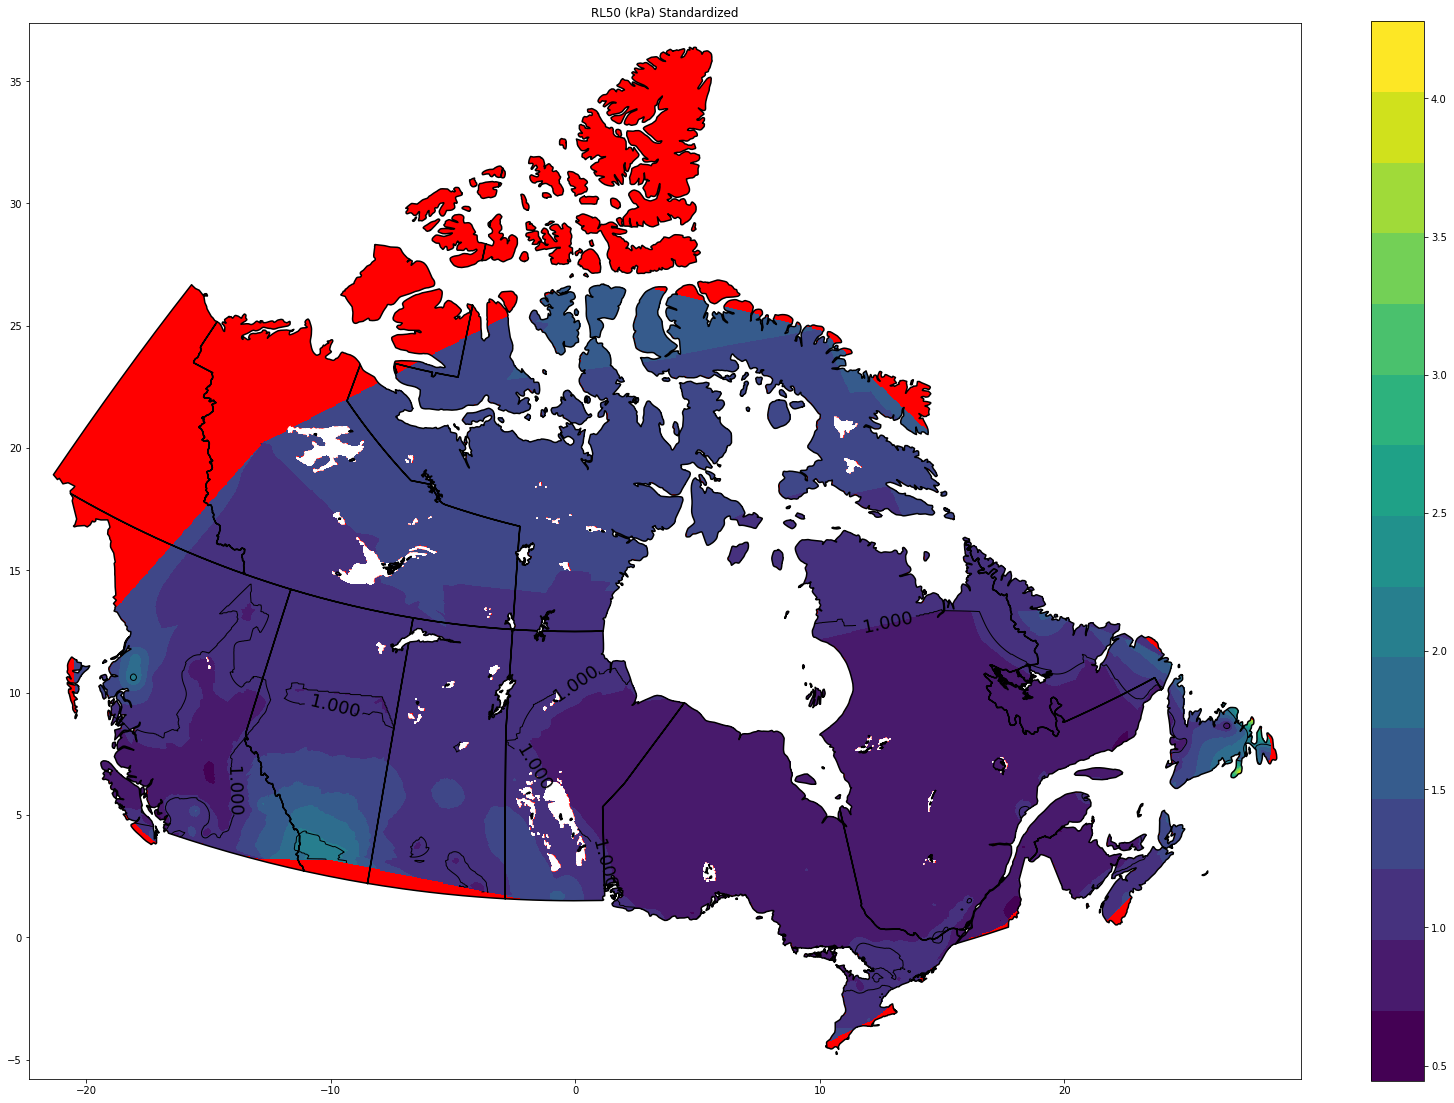

In [34]:
ratio = np.array(ratio, dtype=np.float)


fig, ax = plt.subplots(figsize=(25, 25))

# vmax = np.nanmax(df[station_dv].values)
# vmin = np.nanmin(df[station_dv].values)
# vmin = 5
vmin = 0
vmax = 3


N = 15
cont = np.arange(vmin, vmax, 1)

col1 = ax.imshow(ratio, origin='lower', extent=extent, cmap = plt.cm.get_cmap("viridis", N))
CS = ax.contour(ds.rlon, ds.rlat, ratio, cont, colors='black', linewidths=1, zorder=4)
plt.colorbar(col1, ax = ax, fraction=0.038, pad=0.05)

ax.set_xlim(cxmin-1, cxmax+1)
ax.set_ylim(cymin-1, cymax+1)
ax.clabel(CS, fontsize=18, inline=1)
ax.set_title(station_dv+' Standardized')
canada.plot(ax=ax, color='red', zorder=0)
ax.plot(X, Y, color='black')

plt.savefig(f'./data/plots/standardized-{station_dv}-Z-full-reconstruction-patched.png')

In [35]:
font = {'weight' : 'bold',
        'size'   : 25}

nanmask = ~np.isnan(ratio)
rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)
ratio_final = ratio.copy()

f = NearestNDInterpolator(np.stack([rlon[nanmask], rlat[nanmask]]).T, ratio[nanmask])

ratio_final[nanmask^mask] = f(np.stack([rlon[nanmask^mask], rlat[nanmask^mask]]).T)

ratio_final = ratio_final*mean_corrected.copy()

df_north = df[df.rlat > 60]

start = np.nanmean(ratio_final)/np.nanmean(df_north[station_dv])
print(start)
# enter tolerances
tol = np.linspace(0.1, start*3, 10000)

# diff = np.array([np.nanmean((ratio_final - station_final_north_filled/t)) for t in tol])
# # idx = np.argwhere(np.diff(np.sign(np.zeros(tol.shape) - diff))).flatten()
# best_tol = tol[np.where(np.diff(np.sign(diff)))[0][0]]
# print("SCALE FACTOR:", best_tol, 
#       "YIELDS:", np.nanmedian((ratio_final[df_north.ilocy, df_north.ilocx] - df_north[station_dv]/best_tol)),
#       "DIFF:", np.nanmean((ratio_final[df_north.ilocy, df_north.ilocx] - df_north[station_dv])))

# station_final_north_filled_cp = station_final_north_filled/best_tol

# best_tol = tol[idx][0]

# nanmask = ~np.isnan(ratio_final)


# knr = KNeighborsRegressor(n_neighbors=500, weights='uniform', metric='euclidean')

# north_nan = ~np.isnan(station_final_north)
missed_station_only = (northern_mask^north_nan)

# plt.imshow(missed_station_only, origin='lower', extent=extent)
# plt.gca().set_ylim(M2.bounds.miny.min()-1, M2.bounds.maxy.max()+1)
# plt.gca().set_xlim(M2.bounds.minx.min()-1, M2.bounds.maxx.max()+1)
# plt.show()

# station_final_north[~northern_mask] = np.nan

# rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)
f = NearestNDInterpolator(np.stack([rlon[north_nan], rlat[north_nan]]).T, station_final_north[north_nan])
# # knr.fit(np.stack([rlon[north_nan], rlat[north_nan]]).T, station_final_north[north_nan])
# knr.fit(np.stack([rlon[nanmask].flatten(), rlat[nanmask].flatten()]).T, ratio_final[nanmask])


station_final_north_filled = station_final_north.copy()
station_final_north_filled[missed_station_only] = f(np.stack([rlon[missed_station_only], rlat[missed_station_only]]).T)
# # station_final_north_filled[missed_station_only] = knr.predict(np.stack([rlon[missed_station_only], rlat[missed_station_only]]).T)
# # station_final_north_filled[~northern_mask] = np.nan

# # knr.predict(np.stack([rlon[missed_station_only], rlat[missed_station_only]]).T)

# def fill_with_mean(ratio_final):
#     sample = ratio_final[-410:-210 , :]
#     sample = np.nanmedian(sample, axis=0)
#     sample = np.tile(sample, (ratio_final.shape[0], 1))
#     return sample

# sample = fill_with_mean(ratio_final)
meancopynorth = ds[dv].values.copy()
meancopynorth[northern_mask] = np.nan
YYY = ~np.isnan(station_final_north_UAA)
XXX = ~np.isnan(meancopynorth)

ratio_final_mean_overlap_area = np.nanmean(ratio_final[np.logical_and(YYY, XXX)])
combined_ratio_station_mean = np.mean([ratio_final_mean_overlap_area, UAA_station_mean])

# ratio_final[northern_mask] = np.array(station_final_north_filled)[northern_mask]
# ratio_final[northern_mask] = sample[northern_mask]
ratio_final[northern_mask] = combined_ratio_station_mean
# ratio_final[northern_mask] = 0.0

# ratio_final -= 273.15

# plt.imshow(sample, origin='lower')
# ratio_final -= 273.15
print(combined_ratio_station_mean, ratio_final_mean_overlap_area)

nan
0.09644431019277461 0.1118886203855492


/home/nannau/tri/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


In [36]:
# ratio_final_mean_overlap_area-273.15

In [37]:
ratio_final[northern_mask]

array([0.09644431, 0.09644431, 0.09644431, ..., 0.09644431, 0.09644431,
       0.09644431])

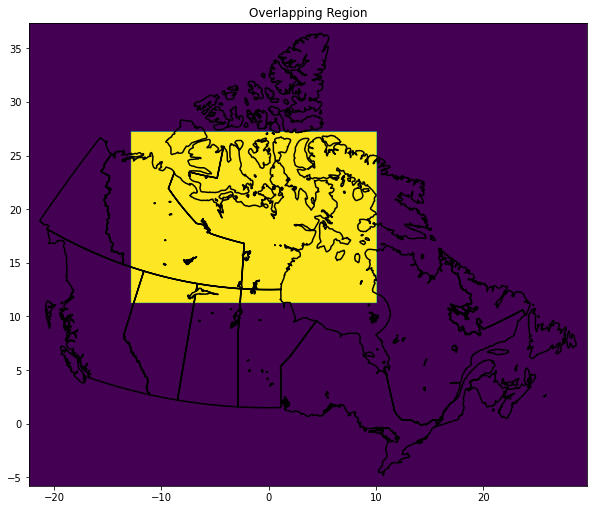

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(np.logical_and(YYY, XXX), origin='lower', extent=extent)
# plt.imshow(XXX, origin='lower')
# plt.imshow(YYY, origin='lower')
# col1 = ax.imshow(ratio, origin='lower', extent=extent, cmap = plt.cm.get_cmap("viridis", N))
# CS = ax.contour(ds.rlon, ds.rlat, ratio, cont, colors='black', linewidths=1, zorder=4)
# plt.colorbar(col1, ax = ax, fraction=0.038, pad=0.05)

ax.set_xlim(cxmin-1, cxmax+1)
ax.set_ylim(cymin-1, cymax+1)
# ax.clabel(CS, fontsize=18, inline=1)
ax.set_title('Overlapping Region')
canada.plot(ax=ax, color='red', zorder=0)
ax.plot(X, Y, color='black')
plt.savefig('overlapping_region.png')

In [39]:
from climpyrical.data import gen_dataset

recon_ds = gen_dataset(dv, ratio_final, ds.rlon, ds.rlat)
recon_ds.to_netcdf(f'/home/nannau/dash-dv-explorer/assets/data/reconstructions/{file_dv}_reconstruction.nc')

In [40]:
from shapely.geometry import MultiPolygon
pts=[]
for poly in canada:
    if isinstance(poly, MultiPolygon):
        for p in poly:
            pts.extend(p.exterior.coords)
            pts.append([None, None])
    else:
        pts.extend(poly.exterior.coords)
        pts.append([None, None])

X, Y = zip(*pts)

In [41]:
# rcopy = ratio_final.copy()
# rcopy[~(ratio_final < -50)] = np.nan

# fig, ax = plt.subplots(figsize=(35, 35))
# ax.imshow(rcopy, origin='lower', extent=extent)
# canada.boundary.plot(ax=ax)
# # ax.set_xlim(25, 35)
# # ax.set_ylim(-20, 0)

# # ratio_final[~(ratio_final < -50)]
ratio_final[ratio_final < 60]

/home/nannau/tri/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


array([0.43472621, 0.43227869, 0.44920559, ..., 0.09644431, 0.09644431,
       0.09644431])

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1]


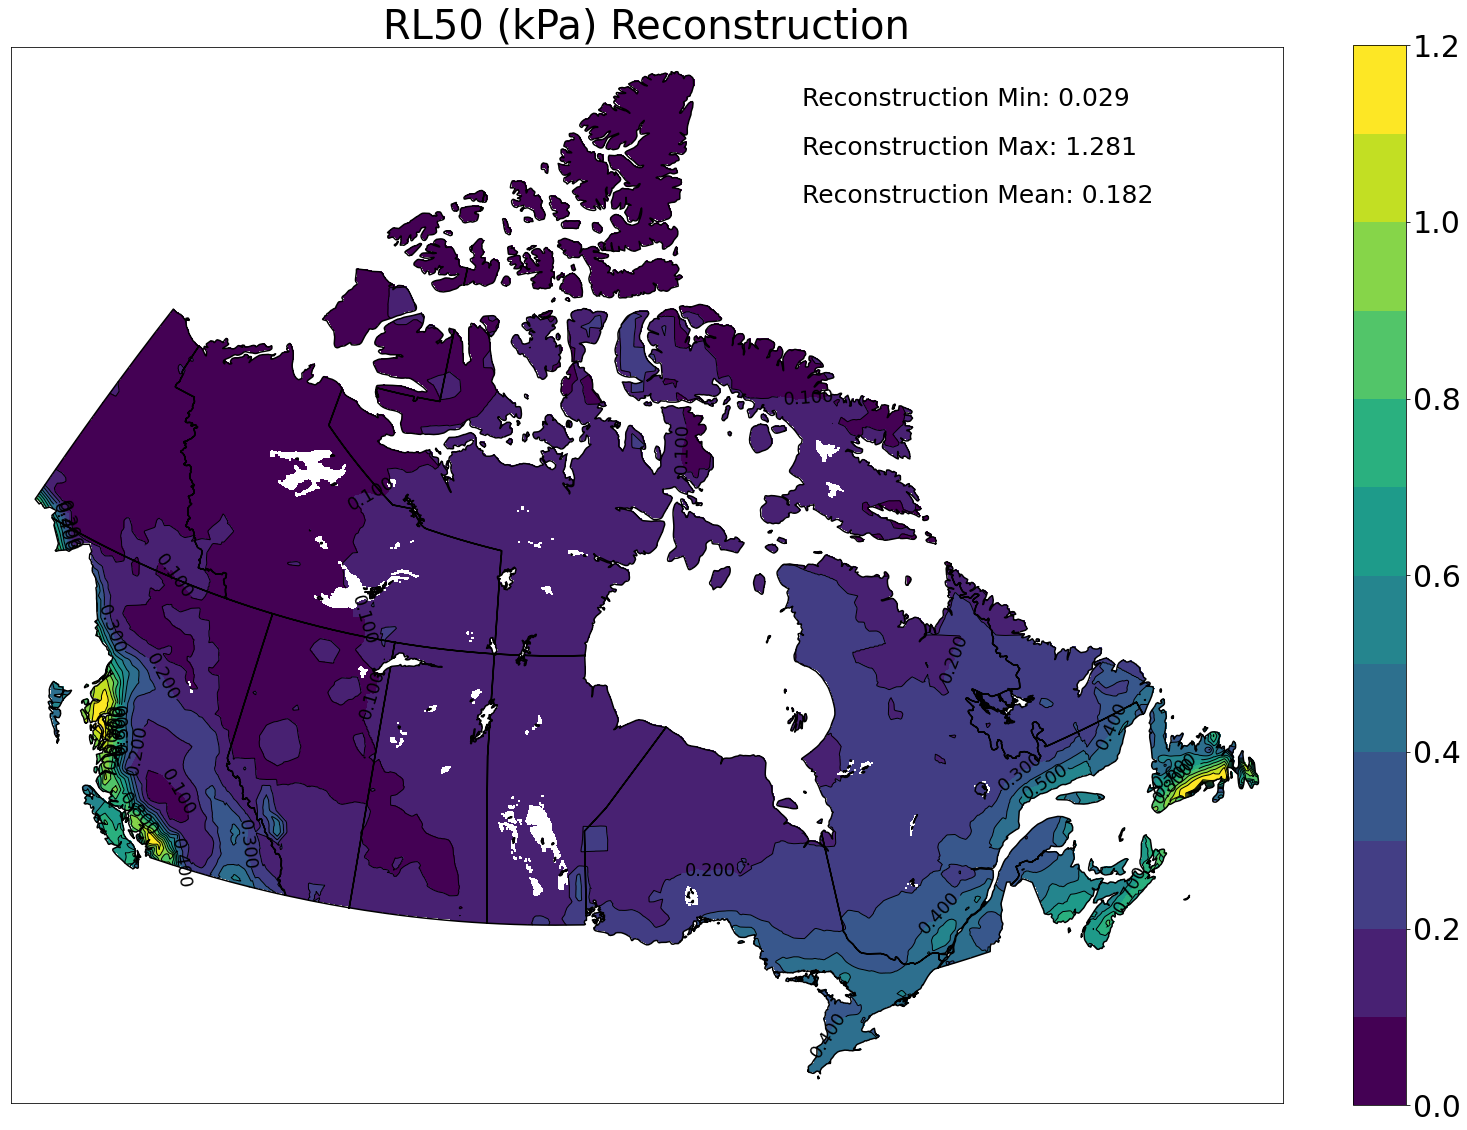

In [45]:
font = {'weight' : 'bold',
        'size'   : 25}

ratio_final[~mask] = np.nan

df = df.assign(station_dv = df[station_dv])# - 273.15)

fig, ax = plt.subplots(figsize=(25, 25))

# vmin = -50
# vmax = 10
# vmin=0
# vmax=15

vmin=0
vmax=1.2
# vmin=1000
# vmax=15000
# vmin = 50
# vmax = 100


N = 12
cont = np.arange(vmin, vmax, 0.1)
print(cont)

ax.text(10, 35, 'Reconstruction Min: {}'.format(np.round(np.nanmin(ratio_final), 3)), fontsize=25)
ax.text(10, 33, 'Reconstruction Max: {}'.format(np.round(np.nanmax(ratio_final), 3)), fontsize=25)
ax.text(10, 31, 'Reconstruction Mean: {}'.format(np.round(np.nanmean(ratio_final), 3)), fontsize=25)

col1 = ax.imshow(ratio_final, origin='lower', extent=extent, vmin=vmin, vmax=vmax, cmap = plt.cm.get_cmap("viridis", N))
CS = ax.contour(ds.rlon, ds.rlat, ratio_final, cont, colors='black', linewidths=1, zorder=4)
cbar = plt.colorbar(col1, ax = ax, fraction=0.038, pad=0.05)
cbar.ax.tick_params(labelsize=30)

ax.set_xlim(cxmin-1, cxmax+1)
ax.set_ylim(cymin-1, cymax+1)

# Hide grid lines
ax.grid(False)


# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])

ax.clabel(CS, fontsize=18, inline=1)
ax.set_title(station_dv+f' Reconstruction', fontsize=40)
# canada.plot(ax=ax, color='red', zorder=0)
ax.plot(X, Y, color='black')

plt.savefig(f'./data/reporting/{file_dv}-reconstruction.png')

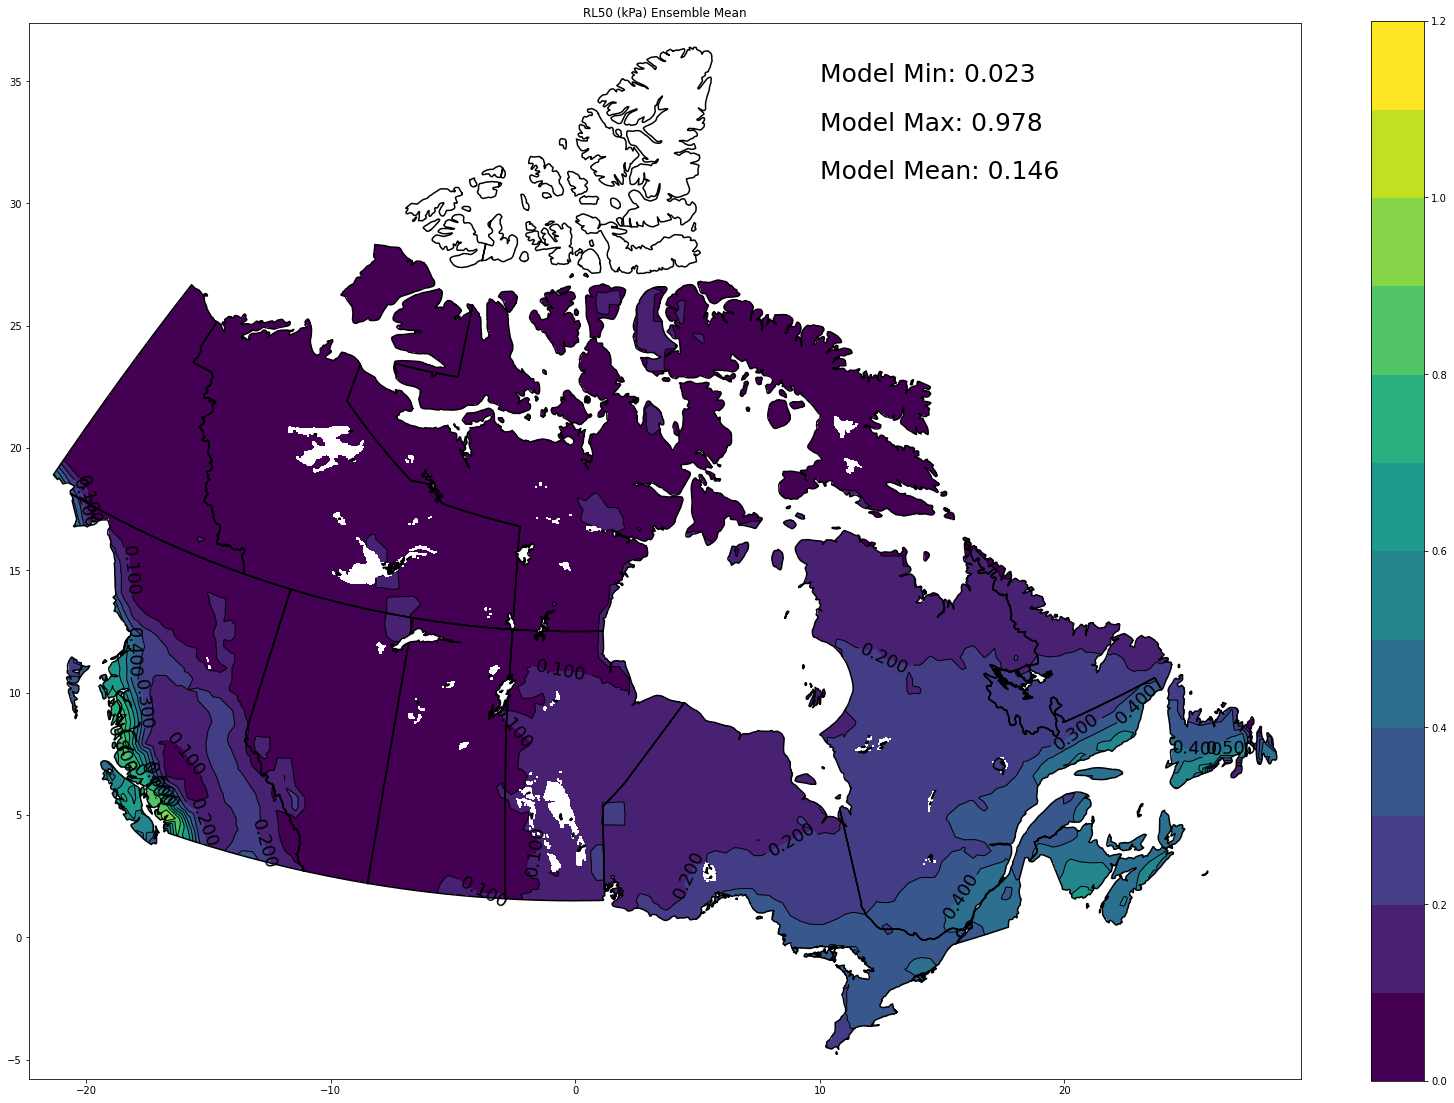

In [46]:
mean = ds[dv].values
mean[~mask] = np.nan
mean[northern_mask] = np.nan
# mean -= 273.15
fig, ax = plt.subplots(figsize=(25, 25))

col1 = ax.imshow(mean, origin='lower', extent=extent, vmin=vmin, vmax=vmax, cmap = plt.cm.get_cmap("viridis", N))
CS = ax.contour(ds.rlon, ds.rlat, mean, cont, colors='black', linewidths=1, zorder=4)
plt.colorbar(col1, ax = ax, fraction=0.038, pad=0.05)

ax.text(10, 35, 'Model Min: {}'.format(np.round(np.nanmin(mean[mask]), 3)), fontsize=25)
ax.text(10, 33, 'Model Max: {}'.format(np.round(np.nanmax(mean[mask]), 3)), fontsize=25)
ax.text(10, 31, 'Model Mean: {}'.format(np.round(np.nanmean(mean[mask]), 3)), fontsize=25)

ax.set_xlim(cxmin-1, cxmax+1)
ax.set_ylim(cymin-1, cymax+1)

ax.clabel(CS, fontsize=18, inline=1)
ax.set_title(station_dv+' Ensemble Mean')
# canada.plot(ax=ax, color='red', zorder=0)
ax.plot(X, Y, color='black')

plt.savefig(f'./data/reporting/{file_dv}_CanRCM4_ensmean.png')

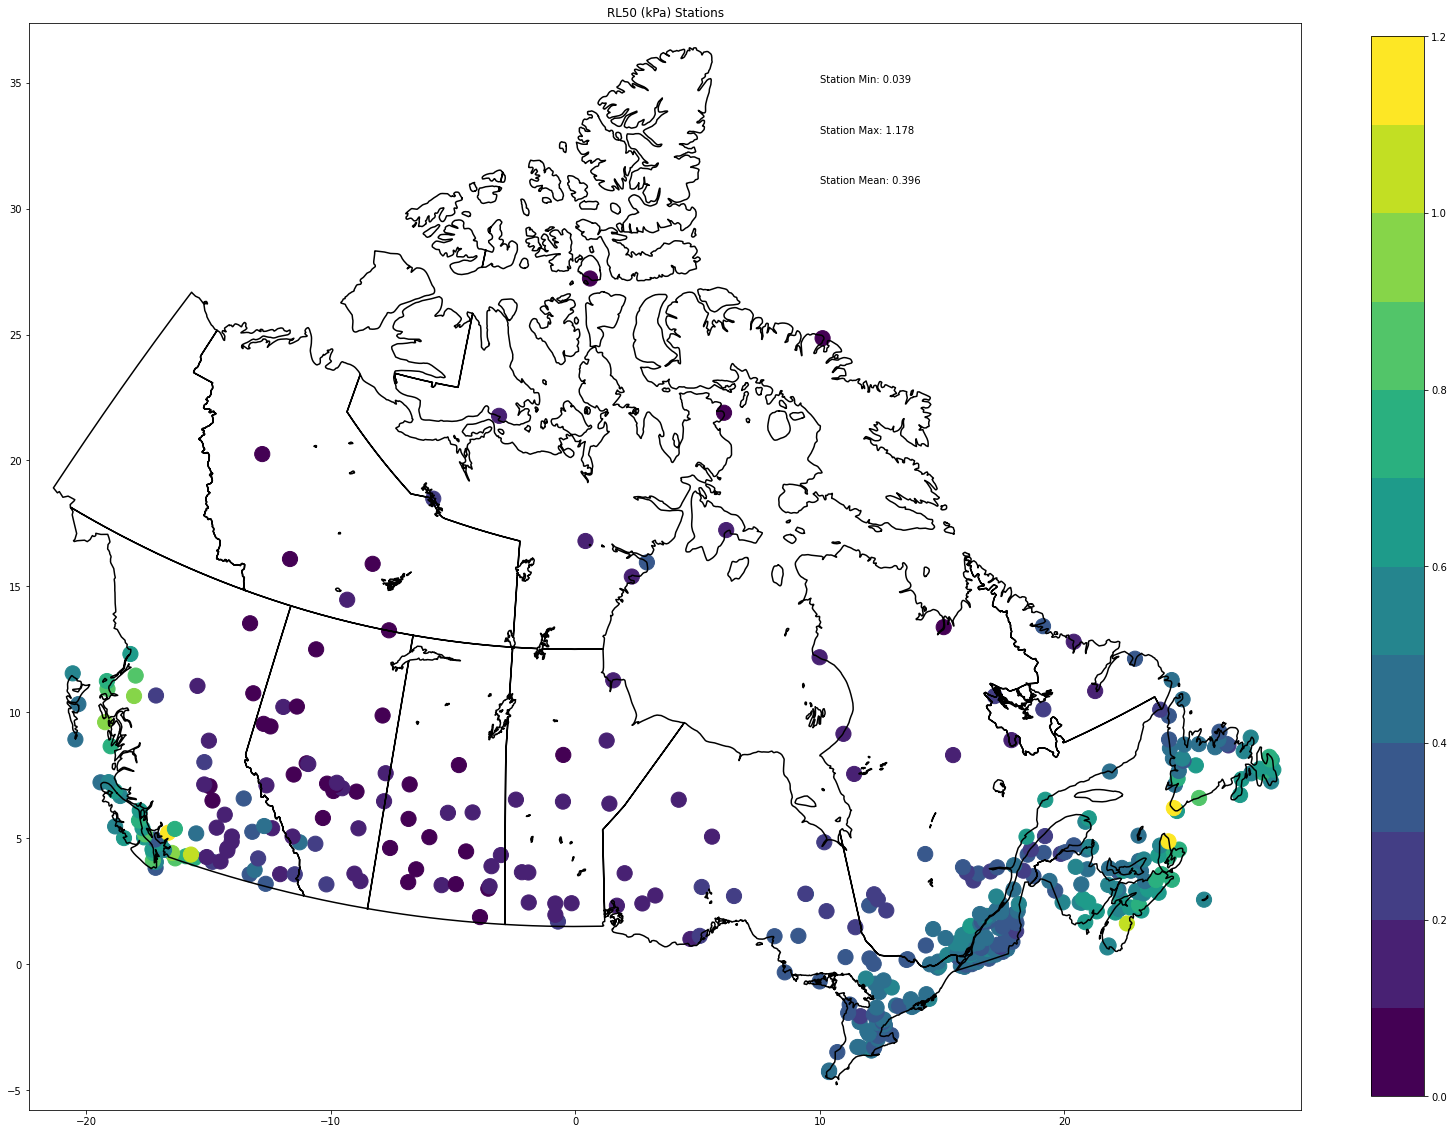

In [48]:
# ratio_final[northern_mask] = np.array(station_final_north_filled)[northern_mask]
# ratio_final[~mask] = np.nan
fig, ax = plt.subplots(figsize=(25, 20))
station_vals_deg_c = df[station_dv] #- 273.15
sc = ax.scatter(df.rlon, df.rlat, c = station_vals_deg_c, s=230, vmin = vmin, vmax = vmax, cmap = plt.cm.get_cmap("viridis", N))
plt.colorbar(sc, ax = ax, fraction=0.038, pad=0.05)

ax.text(10, 35, 'Station Min: {}'.format(np.round(np.min(station_vals_deg_c), 3)))
ax.text(10, 33, 'Station Max: {}'.format(np.max(station_vals_deg_c)))
ax.text(10, 31, 'Station Mean: {}'.format(np.round(np.nanmean(station_vals_deg_c), 3)))

ax.set_xlim(cxmin-1, cxmax+1)
ax.set_ylim(cymin-1, cymax+1)

ax.set_title(station_dv+' Stations')
ax.plot(X, Y, color='black')

plt.savefig(f'./data/reporting/{file_dv}_stations.png')

In [49]:
np.any(mean[mean <0 ]), np.any(ratio_final[ratio_final <0 ])

/home/nannau/tri/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


(False, False)

# Write to Table C-2


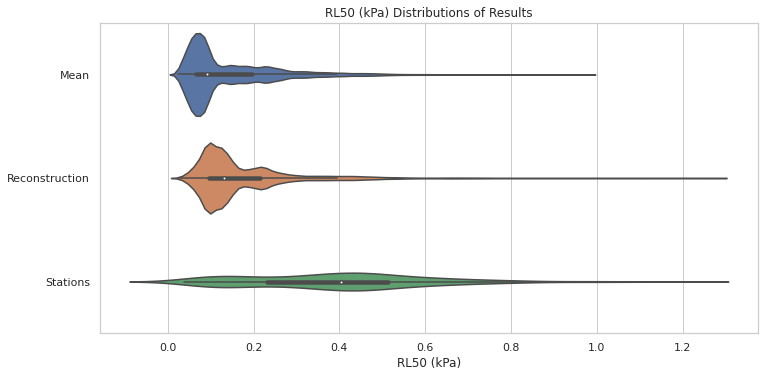

In [50]:
# sns.violinplot
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(10, 5))

violindata = np.concatenate([ds[dv].values.flatten(), ratio_final.flatten(), station_vals_deg_c])

means_str = ["Mean" for x in ds[dv].values.flatten()]
ratio_str = ["Reconstruction" for x in ratio_final.flatten()]
station_str = ["Stations" for x in station_vals_deg_c]

vstrings = np.concatenate([means_str, ratio_str, station_str])

vdf = pd.DataFrame({station_dv: violindata, '': vstrings})
plt.tight_layout()

ax.set_title(f"{station_dv} Distributions of Results")
sns.violinplot(ax=ax, x=station_dv, y='', data=vdf)
plt.savefig(f'./data/reporting/{file_dv}-violin.png', bbox_inches='tight')

In [51]:
matched_df_nrc = pd.read_csv('./data/processed/nrc_locations.csv')

nrc_nan_df = matched_df_nrc[np.isnan(ratio_final[matched_df_nrc.ilocy, matched_df_nrc.ilocx])]

ratio_nan = ~np.isnan(ratio_final)
    
f = NearestNDInterpolator(np.stack([rlon[ratio_nan], rlat[ratio_nan]]).T, ratio_final[ratio_nan])

table_nan = f(
    np.stack(
        [rlon[nrc_nan_df.ilocy.values, nrc_nan_df.ilocx.values], 
         rlat[nrc_nan_df.ilocy.values, nrc_nan_df.ilocx.values]
        ]).T).T

# matched_df_nrc[''][np.isnan(ratio_final[matched_df_nrc.ilocy, matched_df_nrc.ilocx])] = table_nan
# matched_df_nrc

design_value = ratio_final[matched_df_nrc.ilocy, matched_df_nrc.ilocx]
dvnan = np.isnan(design_value)
design_value[dvnan] = table_nan

nrc_table = pd.DataFrame()
nrc_table[station_dv] = design_value
nrc_table = nrc_table.assign(
    Location=matched_df_nrc.Location, 
    lat=matched_df_nrc.lat, 
    lon=matched_df_nrc.lon,
    rlat=matched_df_nrc.rlat, 
    rlon=matched_df_nrc.rlon)

assert not df.isnull().values.any()

nrc_table.round(3).to_csv("./data/reporting/"+file_dv+"TableC2.csv")
nrc_table.round(3).to_csv("/home/nannau/dash-dv-explorer/assets/data/tables/"+file_dv+"TableC2.csv")

In [52]:
file_dv

'RL50'

In [53]:
nrc_table

,RL50 (kPa),Location,lat,lon,rlat,rlon
0,0.109766,100 Mile House,51.64,-121.30,6.472805,-14.893575
1,0.901975,Abbotsford,49.05,-122.33,4.215381,-16.329523
2,0.839248,Agassiz,49.24,-121.76,4.279140,-15.914789
3,0.663538,Alberni,49.27,-124.80,4.957228,-17.785699
4,0.121232,Ashcroft,50.72,-121.28,5.592810,-15.163711
...,...,...,...,...,...,...
674,0.081727,Kugluktuk,67.83,-115.10,21.173542,-7.222514
675,0.183962,Nottingham Island,63.12,-77.93,16.711316,8.872319
676,0.096444,Resolute,74.70,-94.83,27.208988,0.643710
677,0.070299,Resolution Island,61.31,-64.87,17.032368,15.487842


In [54]:
!pwd
!source upload_files.sh

/home/nannau/09092020/climpyrical/notebooks/dev

Welcome to PCIC compute! Please use your Netlink ID to login.


Welcome to PCIC compute! Please use your Netlink ID to login.



In [55]:
pd.read_csv("/home/nannau/dash-dv-explorer/assets/data/tables/Q10_Gumbel-MMTableC2.csv")

,Unnamed: 0,Q10_Gumbel-MM,Location,lat,lon,rlat,rlon
0,0,0.123,100 Mile House,51.64,-121.30,6.473,-14.894
1,1,0.172,Abbotsford,49.05,-122.33,4.215,-16.330
2,2,0.153,Agassiz,49.24,-121.76,4.279,-15.915
3,3,0.166,Alberni,49.27,-124.80,4.957,-17.786
4,4,0.192,Ashcroft,50.72,-121.28,5.593,-15.164
...,...,...,...,...,...,...,...
674,674,0.362,Kugluktuk,67.83,-115.10,21.174,-7.223
675,675,0.439,Nottingham Island,63.12,-77.93,16.711,8.872
676,676,0.429,Resolute,74.70,-94.83,27.209,0.644
677,677,0.637,Resolution Island,61.31,-64.87,17.032,15.488
